### Tweets and User Analysis

Let's try to do an in-depth analysis of tweets and users!
- Build a retweet / mention network
- This could later help with identifying tweets aimed at stirring up controversy
- Seperate content providers from content pushers using retweet count etc.

#### Preprocessing

##### Users
What do we suspect the goal of the Russian operation to be?
- Polarization can only be pushed from the inside! 
- Even the most malleable American will be suscpicous (hopefully) about tweets from users outside of the US on US topics
- We should thus focus on these "content" providers who are pretending to be normal US citizens 
- Remove tweets that contain cyrillic
- Remove users who are self reported to be from Russia
- This includes all these news channels etc
- Highly likely that the IRA also operates domestically, trying to shape Russian opinions
- Zone in on these high reach, fictitcous-american content provider tweets

##### Text
- Hashtags are important, they convey lots of meaning and can be seen as a topic proxy. Could store them in a different section, outside of pure text (note: they are already in the dataframe as a seperate column!) 
- Same holds for mentions and retweets
- Lowercase, remove punctuation
- Remove stopwords 
- Ngrams?
- Stemming
- Lemmatization?

Break the texts down to their core. Polarization is probably going to manifest itself as the joint occurence of decisive topics and strong opinions on it. At least we can try to identify the topics and then get an idea about the sentiment.

### Data Loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Own defined functions (see utils folder)
from utils.cleaning import has_cyrillic, has_arabic

In [3]:
plt.rcParams['figure.figsize'] = (12,10)

In [4]:
# Data loading
tweet_data = pd.read_csv("../data/ira_tweets_en.csv")
user_data = pd.read_csv("../data/ira_users_csv_hashed.csv")

/home/adam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# number of tweets
num_tweets = len(tweet_data)
print(num_tweets)

2997181


In [6]:
# Let's filter out tweets with cyrillc texts
is_cyrillic = tweet_data["tweet_text"].apply(has_cyrillic)

# Remove tweets with cyrillic 
tweet_data = tweet_data[np.invert(is_cyrillic)]

# Getting all the users who tweet in english, cuts down by 600
user_data = user_data[user_data["userid"].isin(tweet_data.userid.unique())].copy()

In [7]:
print(tweet_data.shape)

(2995387, 32)


### Analysis and Cleaning (except tweets)

Let's start with checking the tweet data columns:

In [8]:
tweet_data.columns

Index(['Unnamed: 0', 'tweetid', 'userid', 'user_display_name',
       'user_screen_name', 'user_reported_location',
       'user_profile_description', 'user_profile_url', 'follower_count',
       'following_count', 'account_creation_date', 'account_language',
       'tweet_language', 'tweet_text', 'tweet_time', 'tweet_client_name',
       'in_reply_to_tweetid', 'in_reply_to_userid', 'quoted_tweet_tweetid',
       'is_retweet', 'retweet_userid', 'retweet_tweetid', 'latitude',
       'longitude', 'quote_count', 'reply_count', 'like_count',
       'retweet_count', 'hashtags', 'urls', 'user_mentions', 'poll_choices'],
      dtype='object')

- Tweetid: Just the Id, no meaningful information except maybe for retweets
- UserId: Identifier
- User_disply_name: Some of them are hashed, so we'll only gain info from the non-hashed ones
- User_screen_name & user_reported_location: We can take out tweets whose user report to be outside of the US
- Description and URL: Descripitons are meaningful, could contain information, URL is useless for now
- Follower and following count: Very important for reach 
- Language: Helps us to filter stuff
- Tweet text: Core of our analysis, will dive deeper into preprocessing later
- Tweet_time: UTC time, only in joint analysis with true location useful
- In_reply_to{}: Super useful to establish patterns, but could be hard to make use of without considerable network analysis 
- Quoted: See in_reply_to
- Is retweet: helps us to clean the data
- Latitutde, Longitude: We could make a sexy visualization out of this, will be hard though
- Quote, reply, like count, retweet count: Impact factors
- Hashtags: Super useful for identifying topics

Now for the user data:

In [9]:
user_data.columns

Index(['userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language'],
      dtype='object')

These contain mostly aggregate information on location, description and so on. There is no additional information over the tweets data as far as I can tell. I'll now dive into the single columns and start cleaning / preprocessing on the go.

#### User Description 
I will take the user_data for this, so that I don't need to aggregate on tweets.

- Clean user description
- Remove cyrillic user descriptions
- Analyze words in descriptions
- Try to cluster / group

Notes:
- Some of them are also German, French and so on.
- We'll also need to deal with that.

Some interesting guys (with ID):
- 108: "Print Hillary's face  Pee on it  Send us proofs  Earn money" -> Some Russian TRoll had a good day :D
- 42: "Constitutional Conservative, member of the counterjihad, am against islam and sharia law, sick and tired of politcal correctness, diversity and multiculturalism"
- 217: "#American Patriot #Conservative •Political Blogger •#tcot •Proud Husband of @_SherylGilbert #InGodWeTrust"
- 215: "'I live my own life, #blacktivist'"
- 709: "white people are the most blood thirsty savages the world has ever seen #BLM #ICantBreath"
- 26: "We speak for all fellow members of LGBT community across the nation. Gender preference does not define you. Your spirit defines you."
- 2326: "TX patriots united for real action. GET READY TO SECEDE! #2A  #Texit #TexasSecede #Texodus" -> I mean this guy actively calls for secession, if that's not polarizing then I don't know what is.

Okay very cool, we can already see the polarizing tendencies in this data!

What really confuses me, which was also mentionde in some of the intelligence services analysis are these "mindfulness", "woke" and "free spirit" accounts like these:

- 2957: 'I have learned over the years that when one’s mind is made up, this diminishes fear.'
- 2652: "I give thanks everyday that I've been able to take my craziness and make it work for me."
- 3019: "Be the change that you wish to see in the world"
- 2810: "'I will not drown in the rising tide of conformity. I will not let authority ignore me. #staywoke ☯'"
- 1146: 'To live is the rarest thing in the world. Most people exist, that is all'

Maybe these are supposed to piss of conservatives?

Here's an idea:
- We go through (some of) the 3000 users (shouldn't take too long) and classify them by hand!
- Train some model on the profile descriptions, clustering by political party
- Then use this model to cluster the actual tweets!

Let's first clean the user data based on cyrillic descriptions and later locations!

Some of the profile descriptions are NaN. I will skip these for now.

In [10]:
user_data.user_profile_description.sample(10)

2102    треш угар разговоры о политике #followme #foll...
506     Самое высокое наслаждение — сделать то, чего, ...
11                                                    NaN
1793         Life isn't diamonds & Rose but it SHOULD be!
232                     A threatened blow is seldom given
3314               ★ #ХочуЧитатьВсех  ★#ВзаимныйФолловинг
551     Patriot, Army Veteran from 44 yrs ago, love my...
2662                                 начинающий журналист
854                             Всем сердцем люблю оперу!
3085                                                  NaN
Name: user_profile_description, dtype: object

In [8]:
# Fill NaN values
user_data["user_profile_description"].fillna(value="NaN",inplace = True)

In [9]:
# Checking that it works as intended to:
print(user_data["user_profile_description"].values[0:10])

print([has_cyrillic(desc) for desc in user_data["user_profile_description"].values[0:10]])

['Conservative. Politics. Pro-Life. Writer.  #GodBlessAmerica #WakeUpAmerica #InGodWeTrust'
 'На воре и шапка горит' '❥ ❣ my sweethearts))' 'NaN' 'NaN' 'NaN'
 '#Camden #CamdenNewJersey #NewJersey #USA #America #US #CamdenEvents #CamdenNews'
 'NaN' 'NaN' 'NaN']
[False, True, False, False, False, False, False, False, False, False]


In [10]:
# Filter
mask_cyrillic_desc = user_data["user_profile_description"].apply(has_cyrillic)

print(f"Nr. of users with cyrillic descriptions: {np.sum(mask_cyrillic_desc)}")

Nr. of users with cyrillic descriptions: 818


In [11]:
# Filtering users based on cyrillic profile descriptions.
user_data = user_data.loc[np.invert(mask_cyrillic_desc),].copy()

Now that we've filtered the profile descriptions in cyrillic we can check for the reported languages. Then we filter for only english ones.

#### Reported Account Language

In [12]:
user_data.groupby("account_language").count()["userid"]

account_language
ar         18
de         91
en       1961
en-gb       5
es          8
fr         10
id          1
it          7
ru        136
zh-cn       3
Name: userid, dtype: int64

Okay nice, we have 1961 supposedly english accounts. Let's again filter all the others out. 

In [13]:
user_data = user_data[user_data.account_language == "en"].copy()

#### Locations

Now it's time to check on the locations.

In [14]:
user_data.shape

(1961, 10)

In [15]:
reported_locations = user_data.groupby(user_data.user_reported_location).count()["userid"].sort_values(ascending= False)
reported_locations

user_reported_location
USA                          643
United States                105
Atlanta                       73
US                            60
New York, USA                 41
NY                            33
LA                            29
Boston                        22
New York, NY                  18
New York                      17
Los Angeles                   15
Atlanta, GA                   14
Chicago                       12
Philadelphia                   9
Phoenix                        8
Chicago, IL                    8
Texas, USA                     7
Houston, TX                    7
Arizona                        7
Москва                         7
دمشق                           7
New York City                  6
New-York                       6
London                         6
Los Angeles, CA                6
Washington, DC                 6
Syria                          6
Washington                     5
Washington, D.C.               5
Dallas              

Again some cyrillic or even arabic locations.

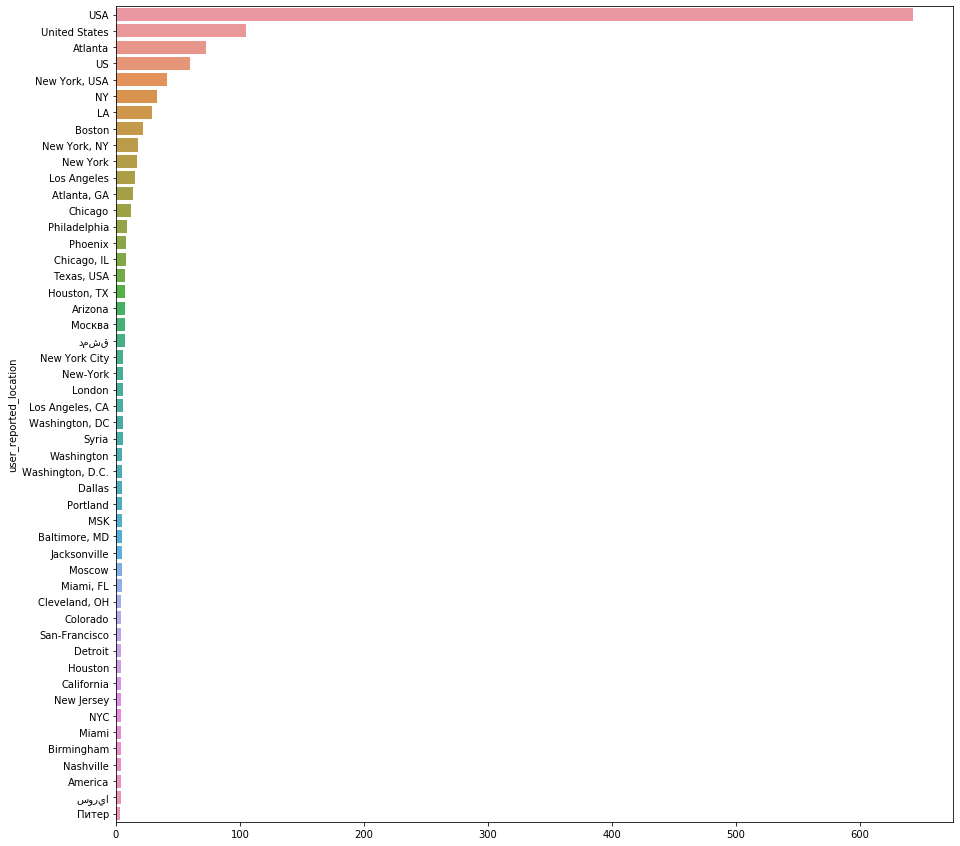

In [19]:
plt.figure(figsize=(15, 15))
sns.barplot(y= reported_locations.iloc[0:50].index, x=reported_locations.iloc[0:50].values);

Again, we'll filter out non-latin letters.

In [16]:
# Check for letters
non_latin_locations= [has_arabic(loc) | has_cyrillic(loc) for loc in reported_locations.index]
print(f"{np.sum(non_latin_locations)} non-latin location descriptions")

35 non-latin location descriptions


In [17]:
# Filter out
user_data = user_data[user_data["user_reported_location"].isin(reported_locations.index[np.invert(non_latin_locations)])].copy()
print(f"{user_data.shape[0]} users left after strict cleaning")

1560 users left after strict cleaning


This has cut down the number of users by almost half! Let's see the impact on the tweets.

In [18]:
print(f"Tweets left: {tweet_data[tweet_data.userid.isin(user_data.userid.values)].shape[0]/num_tweets}")

Tweets left: 0.8462675427343227


In [19]:
tweet_data = tweet_data[tweet_data.userid.isin(user_data.userid.values)].copy()

In [20]:
print(tweet_data.shape)

(2536417, 32)



### News

There are quite a lot of accounts posting "news", these make up a large share of the overall data. We should be aware of that for the subsequent analysis.

In [21]:
# Find news channels
news= ["news" in desc for desc in user_data.user_profile_description]

In [25]:
# Remove
news_accounts = user_data[news]["user_screen_name"]

In [26]:
news_accounts

34      b0e81e4e718dfebdcd4c8601f251963b8859b155d59ad6...
40      5fe1ff96eabcb7e57d3783801171868705c60338201c67...
67                                           DailySanJose
156                                          Seattle_Post
160                                         DailySanDiego
213                                            TodayMiami
246                                       Baltimore0nline
257                                       TodayPittsburgh
475     080da9e6b0c293d8e7abe6115605790ec8bc9a5c75a2b3...
519                                         MinneapolisON
522                                        PhiladelphiaON
673     23dde95f6135ab333fab997ea397603ddf208d1f91a438...
1170                                        OnlineMemphis
1192                                      ChicagoDailyNew
1203                                      KansasDailyNews
1249                                         DailySanFran
1312                                      DetroitDailyNew
1703          

In [31]:
# Filter tweets
tweet_data[tweet_data["user_screen_name"].isin(news_accounts.values)].shape  

(774107, 32)

In [33]:
tweet_data[tweet_data["user_screen_name"].isin(news_accounts.values)].shape[0] / tweet_data.shape[0]

0.30519705553148396

Quite a lot of tweets from these accounts, 30% of the original data.


Let's now dive into the actual tweet data.

### Tweet Data

I'll start with very basic observations:
- Most shared tweets
- Accounts with the most followers
- Accounts who post the most vs. accounts with many retweets


#### The most shared tweets
- In terms of retweet, quote, reply and like counts.

In [31]:
most_quoted = tweet_data.sort_values(by="quote_count", ascending=False)[["user_display_name","tweet_text","quote_count"]]
most_retweeted = tweet_data.sort_values(by="retweet_count", ascending=False)[["user_display_name","tweet_text","retweet_count"]]
most_replies = tweet_data.sort_values(by="reply_count", ascending=False)[["user_display_name","tweet_text","reply_count"]]
most_liked = tweet_data.sort_values(by="like_count", ascending=False)[["user_display_name","tweet_text","like_count"]]

In [32]:
pd.set_option('max_colwidth', 200)
most_quoted.iloc[0:10,][["tweet_text","quote_count"]]

,tweet_text,quote_count
466485,This adorable baby boy's smile is going to completely warm your heart. https://t.co/TWveXVtsJ7,11633.0
2052800,Watch what happens when this big brother spots his little sister after getting off the school bus. It's priceless ❤ https://t.co/DKO2X3NMWa,8765.0
966349,"Nigerian Physician, Dr. Oluyinka Olutoye cut a woman baby out her womb at 23 weeks old, successfully operated on the baby after taking out a tumor, then placed the baby back into the mum's womb &a...",7901.0
2792181,You probably didn't learn this in school: https://t.co/izSRhALylm,7808.0
2080950,Man Gives WAITER a $300 TIP and CRIES! https://t.co/ePU9kl3M8M,7508.0
2313814,For those who support #AltonSterling isn’t it a problem that he had a criminal record and was a convinced pedophile? https://t.co/UedQtzFlzb,6974.0
2953216,These emotions... You can hear the pain in her voice😢 https://t.co/K98Fzep7K3,6196.0
440440,"Oregon man who followed a Black Muslim couple for 20 blocks, yelling racial slurs at them, burst into tears after he was charged with a hate crime. My favorite type of bigot is the crying bigo...",6082.0
2021761,Stop what you're doing and watch these 3-year-old preschoolers confidently (and cutely) spell their names. 😍 https://t.co/uhyAGMwtTN,5190.0
264454,This is so cute! 💘 Daddy made sure to learn his daughter's whole routine in case she forgot. 😍 https://t.co/tHejwGSDUH,4595.0


In [33]:
most_retweeted.iloc[0:10,][["tweet_text","retweet_count"]]

,tweet_text,retweet_count
2196656,Daily reminder that the most educated First Lady in American history is a black woman with two Ivy League degrees from Harvard and Princeton https://t.co/oTBTmu2tCw,123617.0
1983663,Obama (2012) sits alone in a classroom after meeting for hours with parents of Sandy Hook victims. Trump (2018) sits at a disco party he threw at his private night club after spending 14 minutes...,113066.0
2953216,These emotions... You can hear the pain in her voice😢 https://t.co/K98Fzep7K3,97498.0
966349,"Nigerian Physician, Dr. Oluyinka Olutoye cut a woman baby out her womb at 23 weeks old, successfully operated on the baby after taking out a tumor, then placed the baby back into the mum's womb &a...",86619.0
466485,This adorable baby boy's smile is going to completely warm your heart. https://t.co/TWveXVtsJ7,74524.0
1852222,"""This is what white people get to feel like ALL THE TIME?!"" https://t.co/cMvvyNF8gN",65564.0
2052800,Watch what happens when this big brother spots his little sister after getting off the school bus. It's priceless ❤ https://t.co/DKO2X3NMWa,59292.0
62043,Don’t ever tell me kneeling for the flag is disrespectful to our troops when Trump calls a sitting Senator “Pocahontas” in front of Native American war heroes.,51472.0
1722561,"If this little girl's way of reminding her dad to hold her hand isn't one of the cutest 10 seconds of video you've ever seen.. ""Excuse me.""😍 https://t.co/oCrbnCpI0u",51285.0
1069216,This powerful video shows the conversations Black parents give to kids navigating racism https://t.co/cuCtPBSy7v,50217.0


In [34]:
most_replies.iloc[0:10,][["tweet_text","reply_count"]]

,tweet_text,reply_count
99011,"If Comey is “slippery” and Obama is “cheatin”, what do we call a guy sued by pornstar, accused of assault, who got his lawyer's office raided by FBI?",2621.0
440440,"Oregon man who followed a Black Muslim couple for 20 blocks, yelling racial slurs at them, burst into tears after he was charged with a hate crime. My favorite type of bigot is the crying bigo...",2599.0
2706250,"If Comey is “slippery” and Obama is “cheatin”, what do we call a guy sued by pornstar, accused of assault, who got his lawyer's office raided by FBI?",2322.0
854476,"In the light of Sam Nunberg’s on-air meltdown, it seems like a good time to remind everyone: 8 YEARS. 0 SCANDALS. https://t.co/IkY0w99NH3",2173.0
2792181,You probably didn't learn this in school: https://t.co/izSRhALylm,2087.0
1602292,This is priceless! #FakeNews #GA06 #Handel #Ossoff https://t.co/Fn1E1KTqbt,2039.0
2313814,For those who support #AltonSterling isn’t it a problem that he had a criminal record and was a convinced pedophile? https://t.co/UedQtzFlzb,1951.0
2181786,This is Jonathan Smith. He saved 30 people last night before he was shot in the neck. I hope he'll get well soon! #VegasStrong https://t.co/rc6kwhoHcr,1940.0
737993,"8th grader, Kory Terrell is the Texas Spelling Bee champion! Show him some love. These things go unnoticed! ✊🏿✊🏿✊🏿 https://t.co/acpG8QAWqu",1894.0
1942195,Police reopen probe after video surfaces of cop beating homeless woman He also threats to shoot her as she struggles on the ground. https://t.co/k2fAZnD5yd,1747.0


In [35]:
most_liked.iloc[0:10,][["tweet_text","like_count"]]

,tweet_text,like_count
2196656,Daily reminder that the most educated First Lady in American history is a black woman with two Ivy League degrees from Harvard and Princeton https://t.co/oTBTmu2tCw,325826.0
966349,"Nigerian Physician, Dr. Oluyinka Olutoye cut a woman baby out her womb at 23 weeks old, successfully operated on the baby after taking out a tumor, then placed the baby back into the mum's womb &a...",248913.0
1983663,Obama (2012) sits alone in a classroom after meeting for hours with parents of Sandy Hook victims. Trump (2018) sits at a disco party he threw at his private night club after spending 14 minutes...,246722.0
466485,This adorable baby boy's smile is going to completely warm your heart. https://t.co/TWveXVtsJ7,182821.0
2052800,Watch what happens when this big brother spots his little sister after getting off the school bus. It's priceless ❤ https://t.co/DKO2X3NMWa,150461.0
62043,Don’t ever tell me kneeling for the flag is disrespectful to our troops when Trump calls a sitting Senator “Pocahontas” in front of Native American war heroes.,150363.0
2958405,Naylah Williams take's a knee during the National Anthem at Niskayuna High School. https://t.co/JKFYacb8w0,146844.0
1852222,"""This is what white people get to feel like ALL THE TIME?!"" https://t.co/cMvvyNF8gN",136880.0
2953216,These emotions... You can hear the pain in her voice😢 https://t.co/K98Fzep7K3,136013.0
737993,"8th grader, Kory Terrell is the Texas Spelling Bee champion! Show him some love. These things go unnoticed! ✊🏿✊🏿✊🏿 https://t.co/acpG8QAWqu",109952.0


Some observations:
- Huge overlap between the 4 metrics
- Most of them are clearly in either of the directions

### Differentiating between content creators and amplifiers

This is going to be a bit tricky but should help with the text analysis later on.
- Check number of retweets by user
- If the number of retweets as fraction of overall tweets exceeds a certain threshold we can think of these accounts as bots aimed at amplifing the impact


In [34]:
# Percentage of retweets over all tweets by user
retweet_percentage = tweet_data.groupby([tweet_data.userid]).mean()["is_retweet"]

In [35]:
# Percentage of retweets over all tweets by user
retweet_username = tweet_data.groupby([tweet_data.user_screen_name]).mean()["is_retweet"]

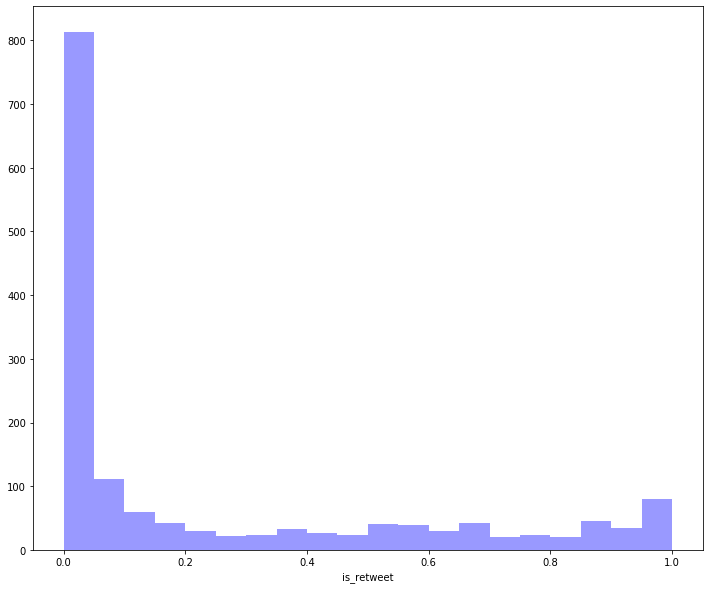

In [36]:
# Let's see the distribution of the retweet percentage
sns.distplot(retweet_percentage, kde=False, bins=20,color ="blue");

Interesting again. Some users only retweet, others never retweet. Let's visualize this by number of tweets in total.

In [37]:
no_tweets = tweet_data.groupby("userid").count()["tweetid"]

/home/adam/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


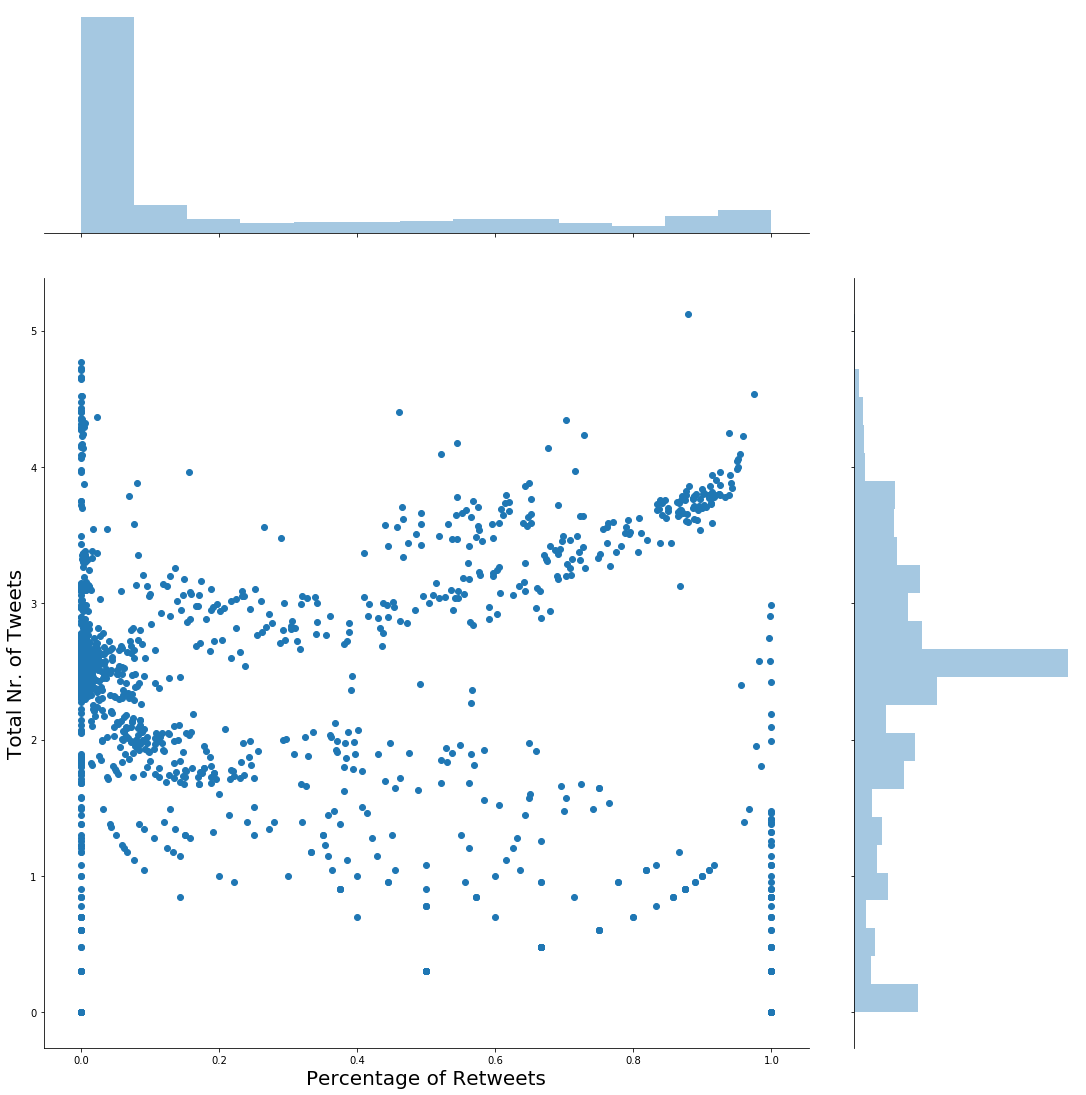

In [38]:
h = sns.jointplot(y = np.log10(no_tweets.values),
                  x= retweet_percentage.values,
                 height = 15,
                 ratio = 3).set_axis_labels("Percentage of Retweets","Total Nr. of Tweets", size = 20)

#h.savefig("retweets")

Let's see the same thing by follower count:

In [39]:
tweet_data[tweet_data.follower_count==tweet_data.follower_count.max()]

,Unnamed: 0,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,...,latitude,longitude,quote_count,reply_count,like_count,retweet_count,hashtags,urls,user_mentions,poll_choices
19,105,626740121648259072,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common ...",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,0.0,2.0,1.0,"[IfAnimalsMadeLaws, EqualityForAll]",[],NaN,NaN
20,106,851098834176487428,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common ...",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,5.0,13.0,12.0,13.0,[],[],NaN,NaN
21,107,851825187267989505,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common ...",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,1.0,5.0,14.0,7.0,[],[],NaN,NaN
22,108,681897201761697792,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common ...",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,100.0,550.0,610.0,[],[],NaN,NaN
23,109,662532293613875201,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common ...",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,0.0,1.0,0.0,[],[],"[3296320187, 164332083]",NaN
24,110,668044460224188416,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common ...",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,3.0,15.0,12.0,[offensive],[],NaN,NaN
25,111,835506064493850625,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common ...",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,9.0,13.0,69.0,50.0,[],[],NaN,NaN
26,112,607812929568636928,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common ...",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,0.0,0.0,0.0,[],[],[742143],NaN
27,113,728636801242566657,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common ...",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,5.0,59.0,34.0,[BodyAcceptance],[],NaN,NaN
28,114,586136580500226048,2882331822,Jenna Abrams,Jenn_Abrams,USA,"Calm down, I'm not pro-Trump. I am pro-common ...",https://t.co/ZXoG0JPLdf,79152,22607,...,absent,absent,0.0,0.0,0.0,3.0,[morningjoe],[],NaN,NaN


Text(0, 0.5, 'Nr. of Followers')

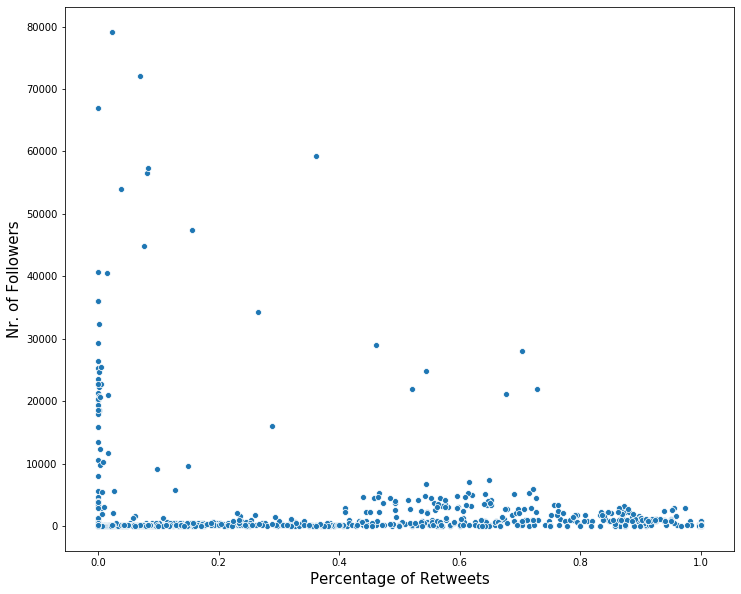

In [40]:
h = sns.scatterplot(y = tweet_data.groupby("userid").mean()["follower_count"], x= retweet_percentage.values)
h.set_xlabel("Percentage of Retweets",fontsize = 15)
h.set_ylabel("Nr. of Followers",fontsize = 15)

Let's see if we can find out some of the famous trolls in the data as content creators

In [41]:
content_creators = retweet_username[retweet_username.values<0.1].index
names_content_creators = [x for x in content_creators if len(x) < 20]

In [42]:
retweet_username[retweet_username.index.isin(names_content_creators)].sort_values()

user_screen_name
SpaceDept          0.000000
DailyLosAngeles    0.000000
PhiladelphiaON     0.000000
DetroitDailyNew    0.000000
WashingtOnline     0.000030
OaklandOnline      0.000069
ChicagoDailyNew    0.000075
NewOrleansON       0.000087
StLouisOnline      0.000087
KansasDailyNews    0.000097
PhoenixDailyNew    0.000117
MinneapolisON      0.000288
DailySanFran       0.000291
Politweecs         0.000315
TodayNYCity        0.000392
Atlanta_Online     0.000423
Seattle_Post       0.000436
DailySanJose       0.000586
OnlineCleveland    0.000586
DailySanDiego      0.000622
Baltimore0nline    0.000650
TodayPittsburgh    0.000876
OnlineMemphis      0.001300
DallasTopNews      0.001806
PigeonToday        0.001954
TodayCincinnati    0.002139
TodayBostonMA      0.002195
patriototus        0.003259
redlanews          0.003849
TodayMiami         0.004105
SanAntoTopNews     0.004233
HoustonTopNews     0.005459
ItsTimeToSecede    0.007172
PamelaKealer13     0.007758
BlackNewsOutlet    0.015625
Blk

Interesting, many of the news accounts post original content. 

Now let's analyse their some user descriptions to identify which side of the polarization they are in.

In [43]:
right_names = ["Jenn_Abrams", "redlanews", "SouthLoneStar", "USA_Gunslinger","patriototus"]
retweet_username[retweet_username.index.isin(right_names)]

user_screen_name
Jenn_Abrams       0.023101
SouthLoneStar     0.037511
USA_Gunslinger    0.077044
patriototus       0.003259
redlanews         0.003849
Name: is_retweet, dtype: float64

In [44]:
tweet_data[tweet_data.user_screen_name.isin(right_names)].groupby(["user_screen_name"])["user_screen_name"].count()

user_screen_name
Jenn_Abrams       23159
SouthLoneStar      3519
USA_Gunslinger     3816
patriototus        1841
redlanews          1559
Name: user_screen_name, dtype: int64

In [45]:
user_data[user_data.user_screen_name.isin(right_names)][["user_screen_name","user_profile_description"]]

,user_screen_name,user_profile_description
320,USA_Gunslinger,"Truth is strong, and sometime or other will pr..."
389,SouthLoneStar,Proud TEXAN and AMERICAN patriot #2a #prolife ...
793,patriototus,Being patriotic means love or devotion to your...
2372,redlanews,Conservative; Right and proud; Christian. Love...
2816,Jenn_Abrams,"Calm down, I'm not pro-Trump. I am pro-common ..."


In [47]:
left_names = ["wokeluisa", "KaniJJackson", "BleepThePolice", "LaChristie", "gloed_up","Blk_Voice"]
retweet_username[retweet_username.index.isin(left_names)]

user_screen_name
BleepThePolice    0.676768
Blk_Voice         0.016340
KaniJJackson      0.265531
LaChristie        0.098592
gloed_up          0.460483
wokeluisa         0.082234
Name: is_retweet, dtype: float64

In [48]:
tweet_data[tweet_data.user_screen_name.isin(left_names)].groupby(["user_screen_name"])["user_screen_name"].count()

user_screen_name
BleepThePolice    13727
Blk_Voice          2142
KaniJJackson       3638
LaChristie         1136
gloed_up          25356
wokeluisa          2274
Name: user_screen_name, dtype: int64

In [49]:
user_data[user_data.user_screen_name.isin(left_names)][["user_screen_name","user_profile_description"]]

,user_screen_name,user_profile_description
58,Blk_Voice,Activist. Feminist. Celebrating and highlighti...
1285,KaniJJackson,"Follow the example set by Mrs Obama; peace, lo..."
2401,LaChristie,Progressive. Activist. Warrior. Inspiration. #...
2844,gloed_up,No black person is ugly #BRONZE #BlackLivesMa...
3337,BleepThePolice,"For a second at least, I'm resurrecting the pe..."
3534,wokeluisa,APSA. #Blackexcellence. Political science...


In [50]:
import pickle

In [51]:
# Saving users and tweets as pickle and csv for later

# Pickle - Tweets
with open('../data/tweets_clean.pickle', 'wb') as f:
    pickle.dump(tweet_data, f)
    
# Pickle - Users
with open('../data/user_clean.pickle', 'wb') as f:
    pickle.dump(user_data, f)

Next up: Tokenization and further preprocessing.

**FOR THE REPORT**

# Data preprocessing
---
<font color=blue>
    
Data preprocess is of capital importance when using natural language processing techniques where different approaches in text cleaning/filtering can lead to very diverse results during model training. In this section we are going to describe and justify the steps we followed to clean our data.
    
## Filtering

In the data set, we find tweets in different alphabets: latin, cyrillic and arabic. The first step in the cleaning process will be then to remove all tweets that are not in latin alphabet, in this case, we will keep english tweets only. Besides not being able to extract any meaning from other alphabets,having different languages/alphabets in the corpus can lead to wrong algorithm output and false vocabularies. Further, since the main target is to show the polarization caused by these tweets in the american society, we believe english is the most relevant language for this objective. 

Another important filter that has been applied is dropping out users that have reported a non US location and/or that don't have their user description or account language in english. Supposedly, having any of the features described above would look suspicious to the "true" american users who these twitters aimed to influence leading to counterproductive effects.

After removing all these tweets from our data, we keep roughly 85% of the original data set, which means 2.5 million tweets.

## Cleaning

Tweets are usually data dirty: punctuation signs are used to give meaning to the tweet, slang is predominant, urls, retweets, hashtags and emojis are frequent. A good cleaning of irrelevant data is key to obtain sensible results.

We proceed removing mentions, retweets, urls, breaklines and innecessary blank spaces. A question that arises when analysing tweets is what to do with emojis. Generally speaking, emojis can be difficult to process but they carry important information about the tweet. In our case, after some preliminary results, we find that emojis don't help much on identifying polarization and, therefore, we removed them from our corpus.

Another point worth mentioning is hashtags. Hashtags provide useful information for identifying the topic and which is the user's opinion about that topic. Since we want to identify polarized information, we believe that these hashtags can shed light to the clustering problem.

## Further preprocessing

A classical approach for data cleaning in classical text-mining techniques is following the Stop Words - Stem - Lemmatize - Tokenize pipeline. However, in the case of short texts such as tweets, some recent voices https://link.springer.com/chapter/10.1007/978-3-319-09339-0_62 arise arguing that lemmatization and stemming lead to worse performance in terms of sentiment analysis, while feature reservation, negation transformation and repeated letters normalization improves it.
Other references as https://link.springer.com/article/10.1023/B:INRT.0000009439.19151.4c claim that lemmatizing and stemming does not improve performance of the algorithms significantly. One has to keep in mind that any morphological pre-processing of the training data reduces the amount of information that model can obtain from the corpus and this can bring noise since some sentences can become ambiguous. Therefore, since there is not clear evidence that we could get a higher performance introducing lemmatization and stemming, we preferred not adding and extra layer of complexity to the problem and stick to the cleaned tokenized raw data. 

SOMETHING ABOUT W2V.

</font>

# Data exploration

<font color=blue>
In this section we will discuss preliminary analysis we can make the cleaned data and we will try to find some evidences that support our thesis about Russian polarization efforts towards Americans.

## Content creators vs content amplifiers

Our hypothesis is that IRA tried to polarize society spreading extremely opposite opinions across all the twitter community. One way to do that is to have some accounts where a human was writing premeditated tweets which were afterwards amplified by bot accounts retweeting this specific tweet. In order to verify this underlying phenomena we plotted in figure XXXX the percentage of retweets per user. A user with high percentage of retweets will be basically retweeting information from other users whereas a user with low percentage will be basically only creating content. 

PLOT: /retweets

In figure on the upper right corner, we see a high concentration of users that, although having a big number of tweets on the data base, they hardly ever produce any content. Whereas in the other extreme, we have users that produce a reasonably amount of tweets but hardly ever retweet. We identify an outlier that has more than 150.000 tweets, which means that over 5 years of data, this user was retweeting an average of 80 tweets per day!

We identified the most active user accounts given by the REPORT NSA,FBI and mueller report and it seems that all of them would fit in the content provider category as we see in table XXX
 </font>


In [ ]:
right_names = ["Jenn_Abrams", "redlanews", "SouthLoneStar", "USA_Gunslinger","patriototus"]
retweet_username[retweet_username.index.isin(right_names)]

In [ ]:
tweet_data[tweet_data.user_screen_name.isin(right_names)].groupby(["user_screen_name"])["user_screen_name"].count()

In [ ]:
left_names = ["wokeluisa", "KaniJJackson", "BleepThePolice", "LaChristie", "gloed_up","Blk_Voice"]
retweet_username[retweet_username.index.isin(left_names)]

In [ ]:
tweet_data[tweet_data.user_screen_name.isin(left_names)].groupby(["user_screen_name"])["user_screen_name"].count()

<font color=blue> Their user description also gives us a clear idea of their political beliefs.<font>

In [ ]:
user_data[user_data.user_screen_name.isin(right_names)][["user_screen_name","user_profile_description"]]

In [ ]:
user_data[user_data.user_screen_name.isin(left_names)][["user_screen_name","user_profile_description"]]

<font color=blue> Their user description also gives us a clear idea of their political beliefs.<font>

In [ ]:
tweets = pd.read_pickle("../data/tweets_preprocessed.pickle")

In [ ]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from utils.wordcloud import plot_wordcloud

tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
# Select tweets from content providers
right_tweets = tweets[tweets.user_screen_name.isin(right_names)]["tweet_text"]
left_tweets = tweets[tweets.user_screen_name.isin(left_names)]["tweet_text"]


# Tokenize tweets
right_tweets_tokenized = [tokenizer.tokenize(t) for t in right_tweets]
left_tweets_tokenized = [tokenizer.tokenize(t) for t in left_tweets]

# Exctract words
right_cluster = [tweet for tweet in right_tweets_tokenized]
left_cluster = [tweet for tweet in left_tweets_tokenized]

In [ ]:
#Word cloud

plot_wordcloud(right_cluster)

In [ ]:
plot_wordcloud(left_cluster)